In [65]:
!rm */.DS_Store
!rm */*/.DS_Store
!rm */*/*/.DS_Store

rm: cannot remove '*/.DS_Store': No such file or directory
rm: cannot remove '*/*/.DS_Store': No such file or directory
rm: cannot remove '*/*/*/.DS_Store': No such file or directory


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import r2_score
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.vision.models import resnet34

import transforms as trans

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
batchsize = 4 # 批大小,
oct_img_size = [512, 512]
image_size = 256
iters = 1000 # 迭代次数
val_ratio = 0.2 # 训练/验证数据划分比例，80 / 20
trainset_root = "STAGE_training/training_images"
test_root = "STAGE_validation/validation_images"
num_workers = 2
init_lr = 1e-4
optimizer_type = "adam"
labellist = {'normal':0,'early':1,'intermediate':2,'advanced':3}

In [5]:
filelists = os.listdir(trainset_root)
train_filelists, val_filelists = train_test_split(filelists, test_size=val_ratio, random_state=42)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))

Total Nums: 200, train: 160, val: 40


In [7]:
class GAMMA_sub1_dataset(paddle.io.Dataset):
    """
    getitem() output:
    
    	fundus_img: RGB uint8 image with shape (3, image_size, image_size)
        
        oct_img:    Uint8 image with shape (256, oct_img_size[0], oct_img_size[1])
    """

    def __init__(self,
                 transforms,
                 dataset_root,
                 label_file='',
                 label_file2='',
                 filelists=None,
                 num_classes=3,
                 mode='train'):

        self.dataset_root = dataset_root
        self.oct_transforms = transforms
        self.mode = mode.lower()
        self.num_classes = num_classes
        
        if self.mode == 'train':
            label = {row['ID']: row[1]
                        for _, row in pd.read_excel(label_file).iterrows()}
            label2 = {row['ID']: row[4]
                        for _, row in pd.read_excel(label_file2).iterrows()}
            self.file_list = [[f, label[int(f)], label2[int(f)]] for f in os.listdir(dataset_root)]
        elif self.mode == "test":
            label2 = {row['ID']: row[4]
                        for _, row in pd.read_excel(label_file2).iterrows()}
            self.file_list = [[f, label2[int(f)],None] for f in os.listdir(dataset_root)]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists]

    def __getitem__(self, idx):
        real_index, label , label2 = self.file_list[idx]

        oct_series_list = sorted(os.listdir(os.path.join(self.dataset_root, real_index)), 
                                    key=lambda x: int(x.strip("_")[0]))

        oct_series_0 = cv2.imread(os.path.join(self.dataset_root, real_index, oct_series_list[0]), 
                                    cv2.IMREAD_GRAYSCALE)
        oct_img = np.zeros((len(oct_series_list), oct_series_0.shape[0], oct_series_0.shape[1], 1), dtype="uint8")

        for k, p in enumerate(oct_series_list):
            oct_img[k] = cv2.imread(
                os.path.join(self.dataset_root, real_index, p), cv2.IMREAD_GRAYSCALE)[..., np.newaxis]

        if self.oct_transforms is not None:
            oct_img = self.oct_transforms(oct_img)
 
        # normlize on GPU to save CPU Memory and IO consuming.
        # fundus_img = (fundus_img / 255.).astype("float32")
        # oct_img = (oct_img / 255.).astype("float32")

        oct_img = oct_img.squeeze(-1) # D, H, W, 1 -> D, H, W

        if self.mode == 'test':
            return oct_img, real_index ,labellist[label]
        if self.mode == "train":
            return oct_img, label, labellist[label2]

    def __len__(self):
        return len(self.file_list)

In [8]:
oct_train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

In [9]:
_train = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        transforms=oct_train_transforms,
                        filelists=train_filelists, 
                        label_file='STAGE_training/training_GT/task1_GT_training.xlsx',
                        label_file2='STAGE_training/data_info_training.xlsx'
                        )

_val = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        transforms=oct_val_transforms,
                        filelists=val_filelists,
                        label_file='STAGE_training/training_GT/task1_GT_training.xlsx',
                        label_file2='STAGE_training/data_info_training.xlsx'
                        )

1
2
0
1
1


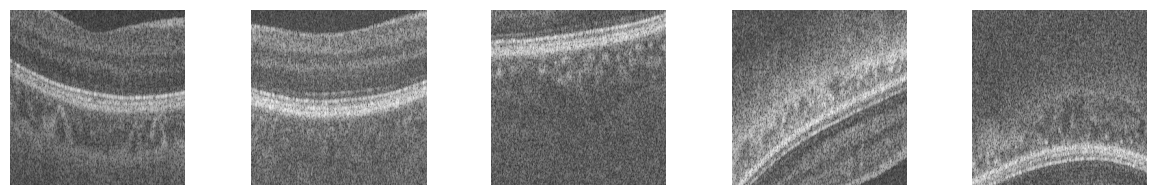

In [71]:
plt.figure(figsize=(15, 5))

for i in range(5):
    oct_img, lab , lab2  = _train.__getitem__(i)
    print(lab2)
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")


In [16]:
class Model(nn.Layer):
    """
    simply create a 2-branch network, and concat global pooled feature vector.
    each branch = single resnet34
    """
    def __init__(self):
        super(Model, self).__init__()
        self.branch = resnet34(pretrained=True, num_classes=0) # 移除最后一层全连接层
        self.linear = nn.Linear(512, 4)
        self.linear2 = nn.Linear(4, 1) 
        self.sigmoid = nn.Sigmoid()
        # 在oct_branch更改第一个卷积层通道数
        self.branch.conv1 = nn.Conv2D(256, 64,
                                        kernel_size=7,
                                        stride=2,
                                        padding=3,
                                        bias_attr=False)
        


    def forward(self,input):
        b = self.branch(input)
        b = paddle.flatten(b, 1)
        blogit = self.linear(b)
        logit = self.linear2(blogit)
        logit = self.sigmoid(logit)
        return logit , blogit


In [10]:
class SMAPELoss(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
 
    def forward(self, labels,preds,):
        return 1 / len(preds) * paddle.sum(2 * paddle.abs(preds - labels) / (paddle.abs(preds) + paddle.abs(labels)))

def Smape_(labels,preds):
    return 1 / len(preds) * paddle.sum(2 * paddle.abs(preds - labels) / (paddle.abs(preds) + paddle.abs(labels)))
               
def process(logits,labels):
    logits = logits.squeeze()
    label = [ 1 if i == 0 else i * (-6)  for i in labels.numpy()] 
    return logits * paddle.to_tensor(label)
  
def R2(preds, labels):
    return 1 - paddle.sum((preds - labels) ** 2) / paddle.sum((labels - labels.mean()) ** 2)

def Score(smape, R2):
    return  0.5 * (1 / (smape + 0.1)) + 0.5 * (R2 * 10)


In [11]:
def train(model,iters, train_dataloader, val_dataloader, optimizer, criterion, log_interval, eval_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_score_list = []
    avg_kappa_list = []
    best_score = -999
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            
            
            oct_imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype("float32")
            labels2 = data[2].astype('int64')

            logits , blogits = model(oct_imgs)
         
            logits = process(logits, labels2)
            

            smape = Smape_(labels,logits)
            r2 = r2_score(labels,logits)
            loss = criterion(labels,logits)

            
            avg_score_list.append(Score(smape,r2).numpy()[0])
            avg_loss_list.append(loss.numpy()[0])
            
            for p, l in zip(blogits.numpy().argmax(1), labels2.numpy()):
                avg_kappa_list.append([p, l])

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            
            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_score = np.array(avg_score_list).mean()
                avg_loss_list = []
                avg_score_list = []
                avg_kappa_list = np.array(avg_kappa_list)
                avg_kappa = cohen_kappa_score(avg_kappa_list[:, 0], avg_kappa_list[:, 1], weights='quadratic')
                avg_kappa_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_acore={:.4f} avg_kappa={:.4f}".format(iter, iters, avg_loss, avg_score,avg_kappa))

            if iter % eval_interval == 0:
                avg_loss, avg_score, avg_kappa = val(model, val_dataloader, criterion)
                print("[EVAL] iter={}/{} avg_loss={:.4f} acore={:.4f} akappa={:.4f}".format(iter, iters, avg_loss, avg_score,avg_kappa))
                if avg_score >= best_score:
                    best_score = avg_score
                    paddle.save(model.state_dict(),
                            os.path.join("best_model_{:.4f}".format(best_score), 'model.pdparams'))
                model.train()

def val(model, val_dataloader, criterion):
    model.eval()
    avg_loss_list = []
    avg_kappa_list = []
    avg_score_list = []
    with paddle.no_grad():
        for data in val_dataloader:
            oct_imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            labels2 = data[2].astype('int64')
            logits, blogits = model(oct_imgs)
            
            logits = process(logits, labels2)
            smape = Smape_(labels,logits)
            r2 = r2_score(labels,logits)
            
            for p, l in zip(blogits.numpy().argmax(1), labels2.numpy()):
                avg_kappa_list.append([p, l])
                
            loss = criterion(labels,logits)
            # loss = criterion(blogits, labels2)
            # acc = paddle.metric.accuracy(input=logits, label=labels.reshape((-1, 1)), k=1)
            avg_loss_list.append(loss.numpy()[0])
            avg_score_list.append(Score(smape,r2).numpy()[0])
            
    avg_score = np.array(avg_score_list).mean()
    avg_loss = np.array(avg_loss_list).mean()
    avg_kappa_list = np.array(avg_kappa_list)
    avg_kappa = cohen_kappa_score(avg_kappa_list[:, 0], avg_kappa_list[:, 1], weights='quadratic')
    return avg_loss, avg_score , avg_kappa


In [12]:
train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

train_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        transforms=train_transforms,
                        filelists=train_filelists,
                        label_file='STAGE_training/training_GT/task1_GT_training.xlsx',
                        label_file2='STAGE_training/data_info_training.xlsx')

val_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        transforms=val_transforms,
                        filelists=val_filelists,
                        label_file='STAGE_training/training_GT/task1_GT_training.xlsx',
                        label_file2='STAGE_training/data_info_training.xlsx')

In [13]:
train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

In [17]:
paddle.device.set_device('gpu:3')
model = Model()

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())

criterion = SMAPELoss()
# criterion = nn.CrossEntropyLoss()

W0717 04:31:04.112354 18264 gpu_resources.cc:61] Please NOTE: device: 3, GPU Compute Capability: 7.5, Driver API Version: 11.4, Runtime API Version: 10.1
W0717 04:31:04.120834 18264 gpu_resources.cc:91] device: 3, cuDNN Version: 7.6.


In [79]:
train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=100)

[TRAIN] iter=10/1000 avg_loss=1.1377 avg_acore=-2.7585 avg_kappa=-0.0857
[TRAIN] iter=20/1000 avg_loss=0.8174 avg_acore=0.1059 avg_kappa=0.0577
[TRAIN] iter=30/1000 avg_loss=0.9046 avg_acore=-2.6245 avg_kappa=-0.0458
[TRAIN] iter=40/1000 avg_loss=0.8018 avg_acore=1.8274 avg_kappa=0.0323
[TRAIN] iter=50/1000 avg_loss=0.7829 avg_acore=-3.8719 avg_kappa=0.1250
[TRAIN] iter=60/1000 avg_loss=0.6986 avg_acore=-6.5652 avg_kappa=-0.0829
[TRAIN] iter=70/1000 avg_loss=0.7672 avg_acore=-6.5819 avg_kappa=0.1406
[TRAIN] iter=80/1000 avg_loss=0.5658 avg_acore=2.9402 avg_kappa=0.1698
[TRAIN] iter=90/1000 avg_loss=0.6881 avg_acore=-0.5259 avg_kappa=0.1083
[TRAIN] iter=100/1000 avg_loss=0.6012 avg_acore=-12.5766 avg_kappa=-0.0829
[EVAL] iter=100/1000 avg_loss=1.4844 acore=-2.7236 akappa=-0.1803
[TRAIN] iter=110/1000 avg_loss=0.7423 avg_acore=-5.6929 avg_kappa=-0.2082
[TRAIN] iter=120/1000 avg_loss=0.6958 avg_acore=-0.3131 avg_kappa=0.1557
[TRAIN] iter=130/1000 avg_loss=0.6850 avg_acore=1.5977 avg_kappa

In [83]:
best_model_path = "./best_model_2.5717/model.pdparams"
model = Model()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

In [81]:

oct_test_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

test_dataset = GAMMA_sub1_dataset(dataset_root=test_root, 
                        transforms=oct_test_transforms,
                        label_file2='STAGE_validation/data_info_validation.xlsx',
                        mode='test')

In [87]:
cache = []
for oct_img, idx , labels2 in test_dataset:
    oct_img = oct_img[np.newaxis, ...]
    oct_img = paddle.to_tensor((oct_img / 255.).astype("float32"))

    logits , blogits = model(oct_img)
    if labels2 != 0:
        logits = logits.squeeze() * labels2 * (-6)

    cache.append([idx, logits.numpy()])
submission_result = pd.DataFrame(cache, columns=['ID', 'pred_MD'])
submission_result.to_csv("./MD_Results.csv", index=False)

: 